<a href="https://colab.research.google.com/github/Lois-Lanctot/student-performance-analysis/blob/main/student_performance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# exams.csv

In [41]:
exams_df = pd.read_csv("/content/exams.csv")
exams_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [42]:
# exams_df.info()
print("Columns: ", exams_df.columns)
print("Record Count: ", len(exams_df))

Columns:  Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')
Record Count:  1000


In [43]:
print(exams_df.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [44]:
print(exams_df['gender'].unique())
print(exams_df['race/ethnicity'].unique())
print(exams_df['parental level of education'].unique())
print(exams_df['lunch'].unique())
print(exams_df['test preparation course'].unique())


['female' 'male']
['group D' 'group B' 'group C' 'group E' 'group A']
['some college' "associate's degree" 'some high school'
 "bachelor's degree" "master's degree" 'high school']
['standard' 'free/reduced']
['completed' 'none']


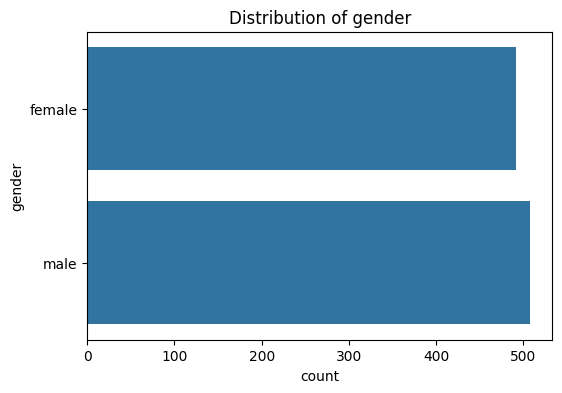

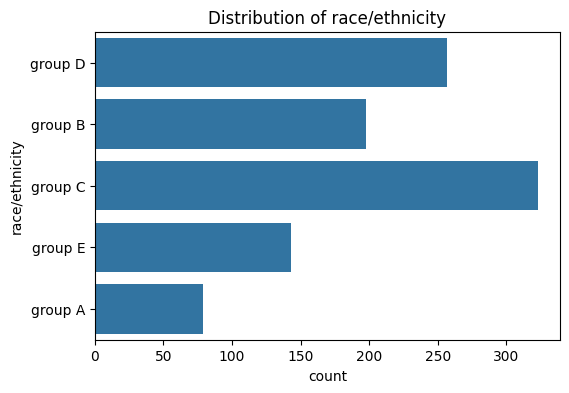

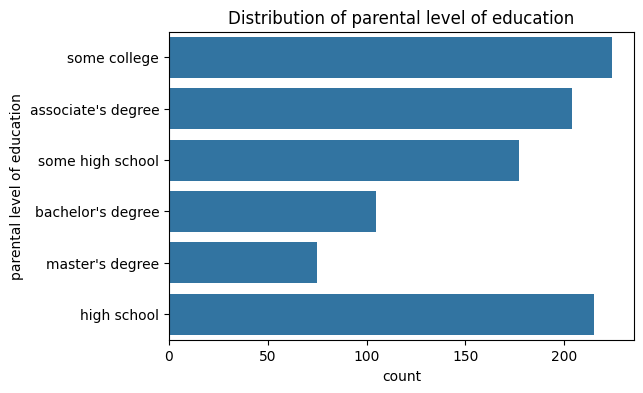

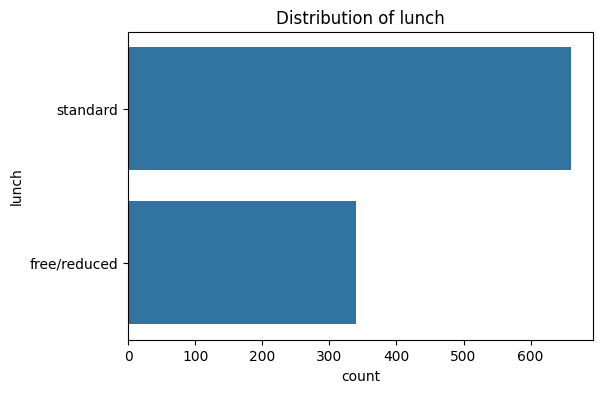

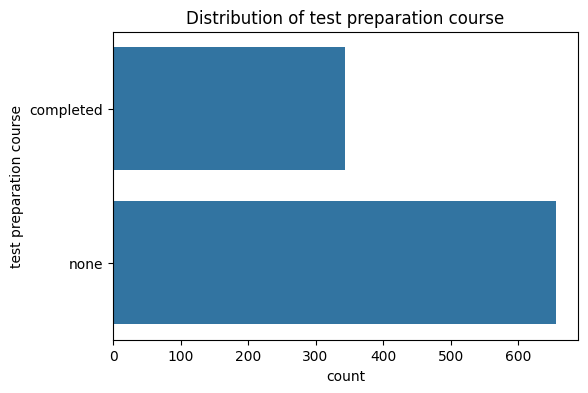

In [45]:
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(exams_df[col])
    plt.title(f'Distribution of {col}')
    plt.show()


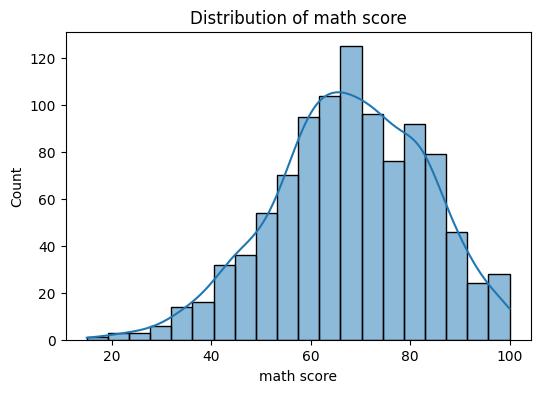

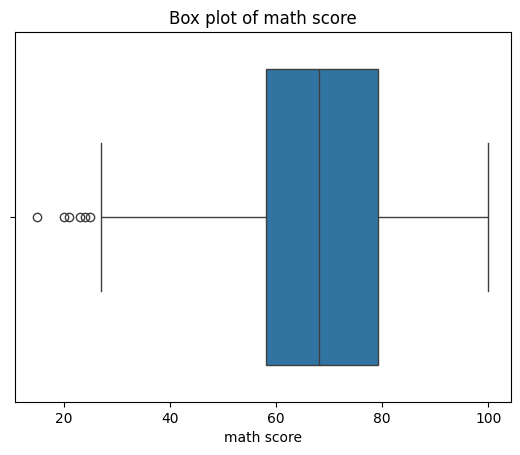

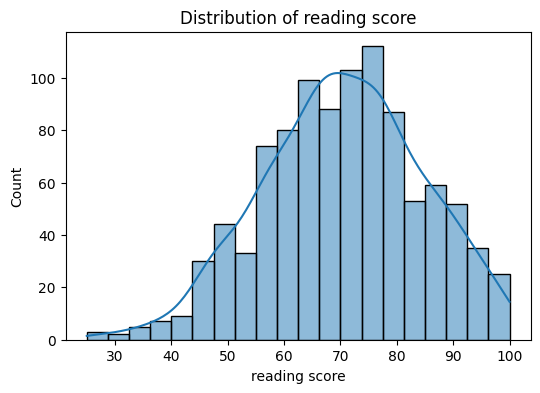

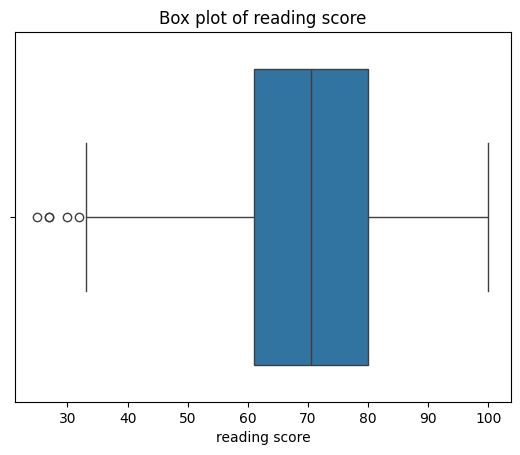

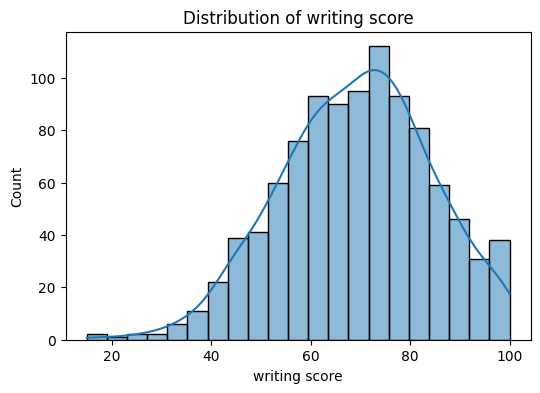

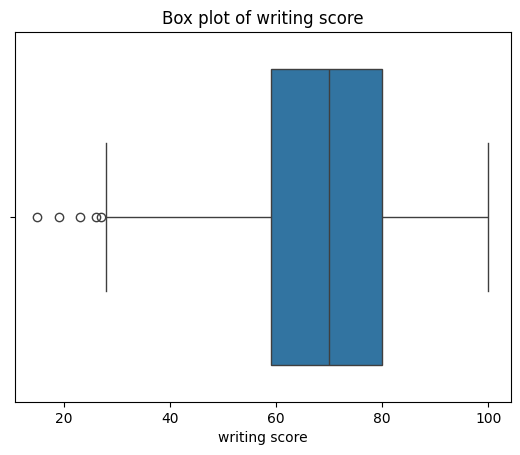

In [46]:
numerical_cols = ['math score', 'reading score', 'writing score']
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(exams_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    sns.boxplot(x=exams_df[col])
    plt.title(f'Box plot of {col}')
    plt.show()


In [47]:
# remove outliers
columns_to_check = [
    'gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'
]
z_scores = stats.zscore(exams_df[columns_to_check].select_dtypes(include=['float64', 'int64']), nan_policy='omit')
exams_df = exams_df[(abs(z_scores) < 3).all(axis=1)]

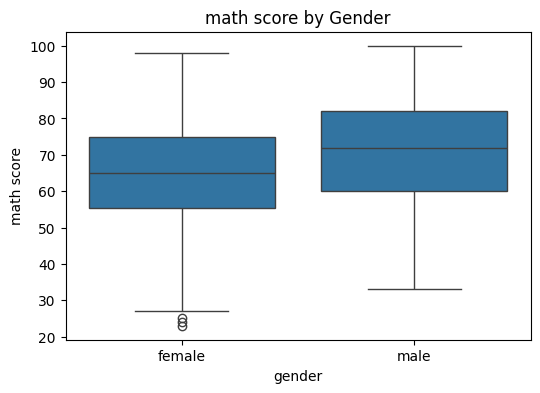

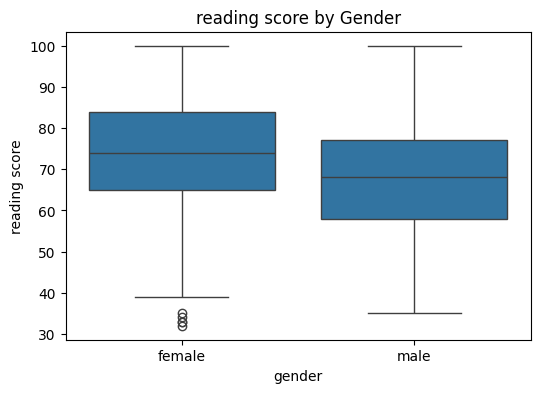

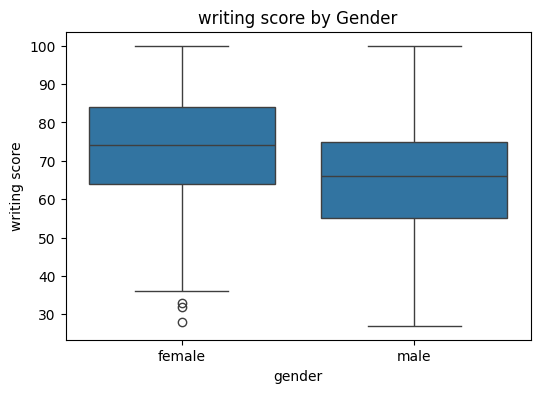

In [48]:
# analyze the relationship between gender and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='gender', y=col, data=exams_df)
    plt.title(f'{col} by Gender')
    plt.show()


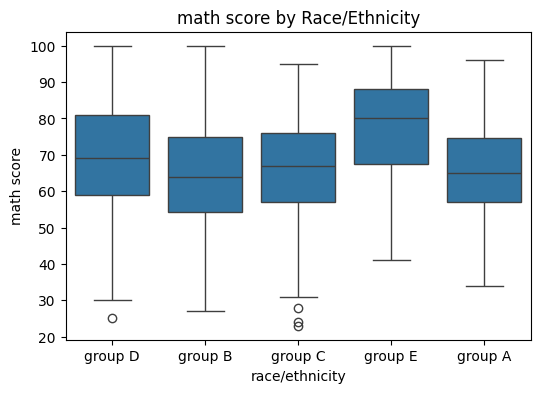

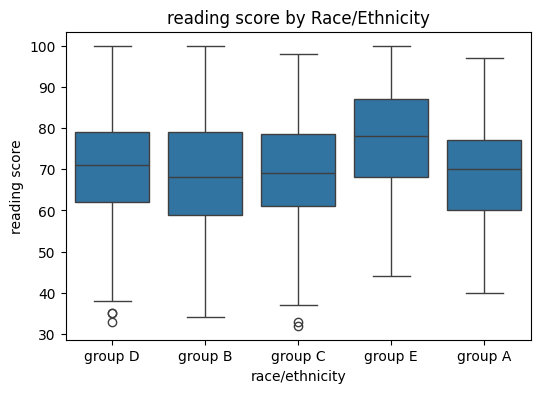

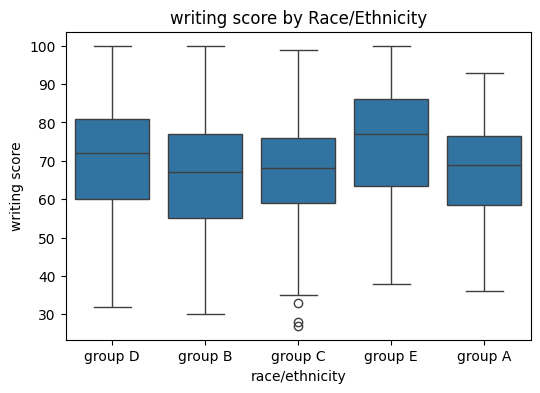

In [49]:
# analyze the relationship between race and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='race/ethnicity', y=col, data=exams_df)
    plt.title(f'{col} by Race/Ethnicity')
    plt.show()


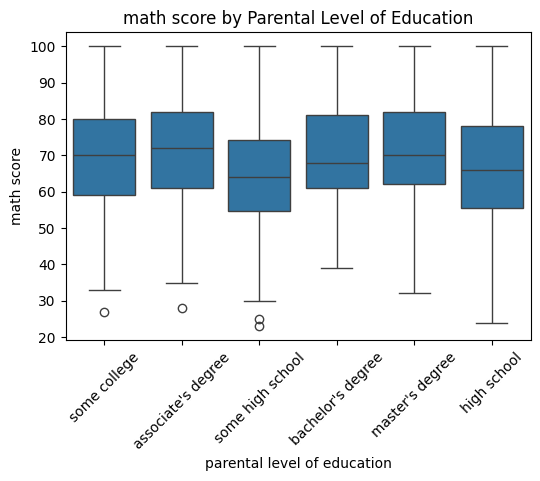

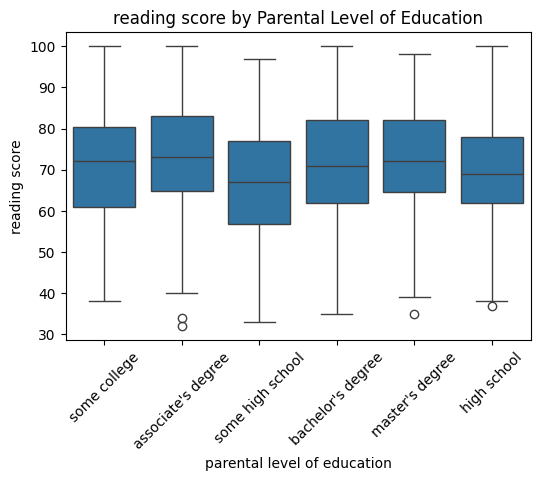

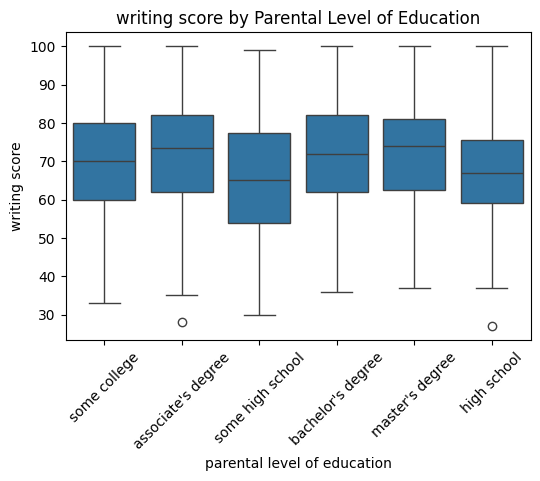

In [50]:
# analyze the relationship between parental education and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='parental level of education', y=col, data=exams_df)
    plt.xticks(rotation=45)
    plt.title(f'{col} by Parental Level of Education')
    plt.show()


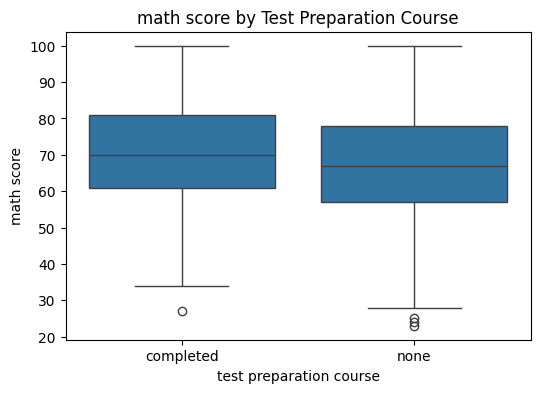

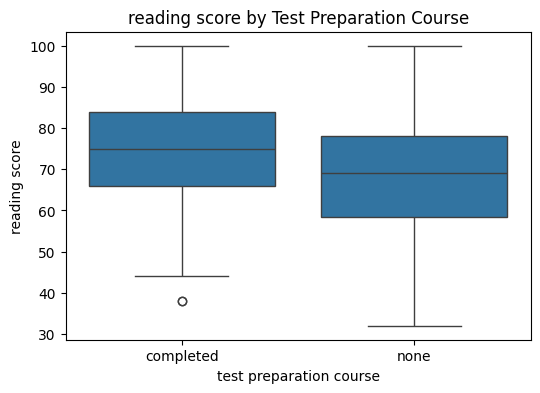

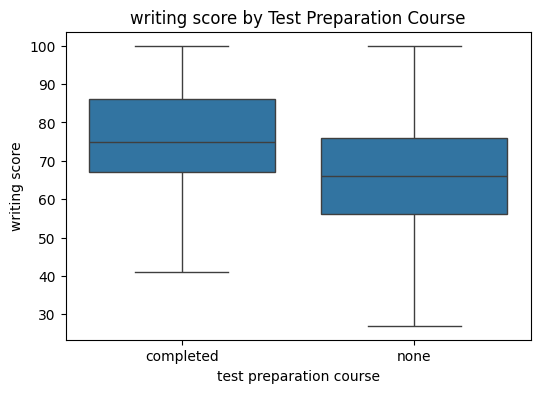

In [51]:
# analyze the relationship between test preparation course completion and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='test preparation course', y=col, data=exams_df)
    plt.title(f'{col} by Test Preparation Course')
    plt.show()


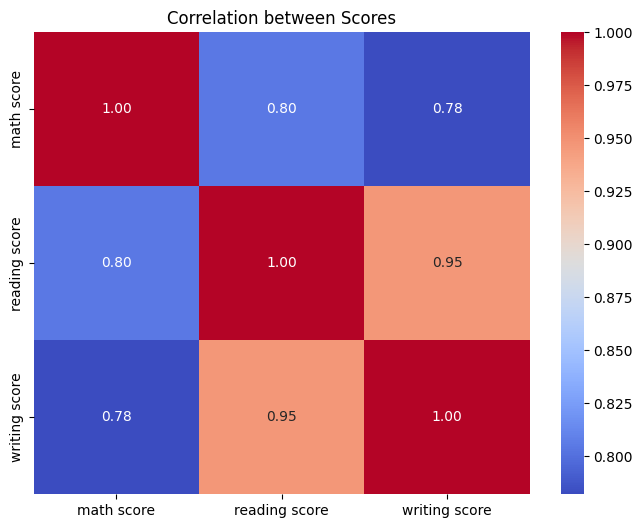

In [52]:
# Correlation heatmap between scores
plt.figure(figsize=(8, 6))
sns.heatmap(exams_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Scores')
plt.show()


# StudentPerformanceFactors

In [53]:
large_df = pd.read_csv("/content/StudentPerformanceFactors.csv") # some missing values
large_df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [54]:
# large_df.info()
print("Columns: ", large_df.columns)
print("Record Count: ", len(large_df))

Columns:  Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender',
       'Exam_Score'],
      dtype='object')
Record Count:  6607


In [55]:
print(large_df.isnull().sum())

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64


In [56]:
# handle missing data types by filling in the missing values
large_df['Teacher_Quality'].fillna(large_df['Teacher_Quality'].mode()[0], inplace=True)
large_df['Parental_Education_Level'].fillna(large_df['Parental_Education_Level'].mode()[0], inplace=True)
large_df['Distance_from_Home'].fillna(large_df['Distance_from_Home'].mode()[0], inplace=True)

print(large_df.isnull().sum())

Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64


<ipython-input-56-3bdf4f60a3a0>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  large_df['Teacher_Quality'].fillna(large_df['Teacher_Quality'].mode()[0], inplace=True)
<ipython-input-56-3bdf4f60a3a0>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

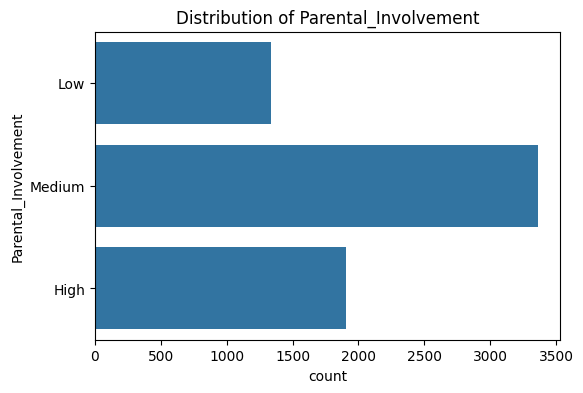

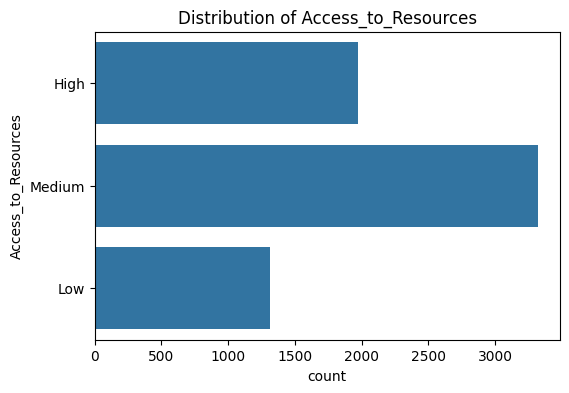

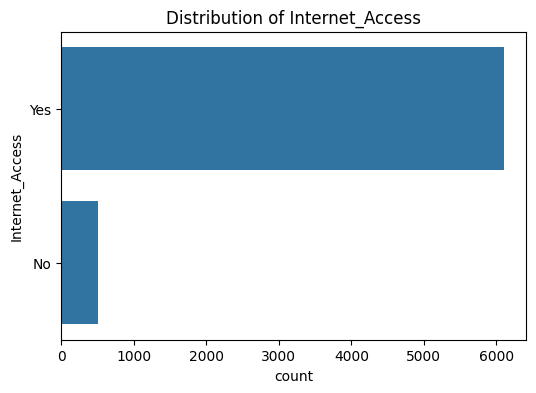

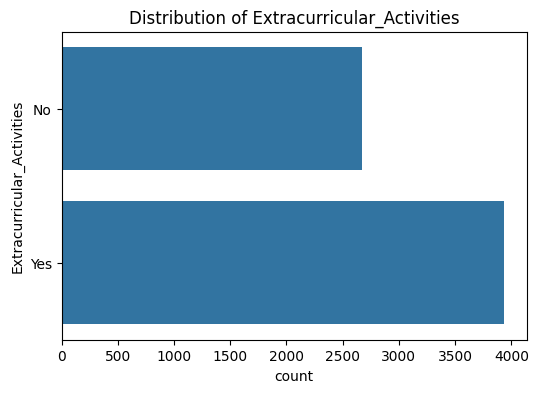

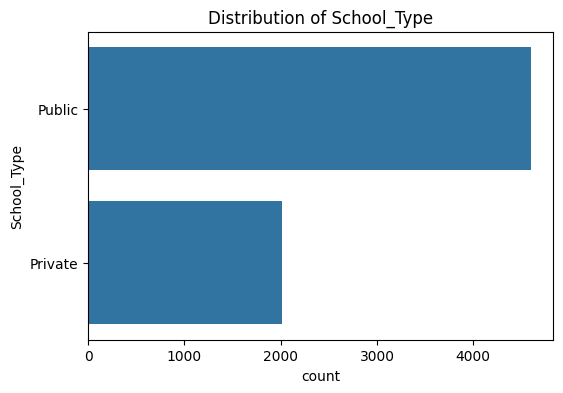

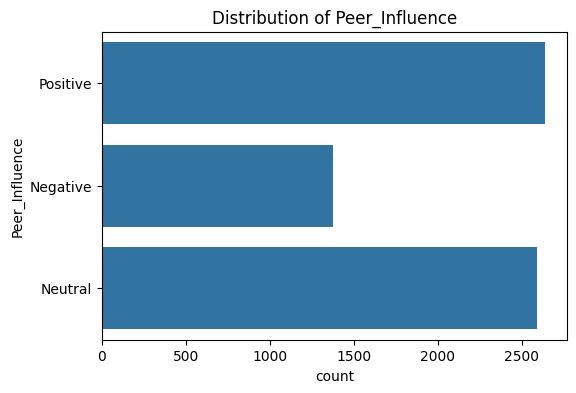

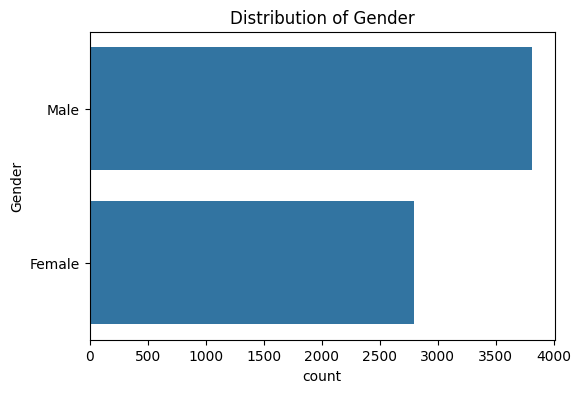

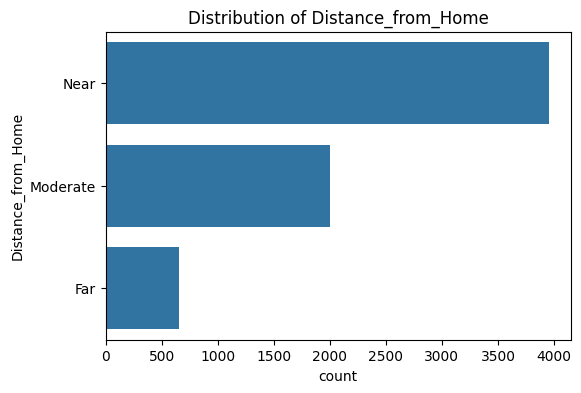

In [57]:
categorical_cols = ['Parental_Involvement', 'Access_to_Resources', 'Internet_Access',
                    'Extracurricular_Activities', 'School_Type', 'Peer_Influence', 'Gender', 'Distance_from_Home']
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(large_df[col])
    plt.title(f'Distribution of {col}')
    plt.show()


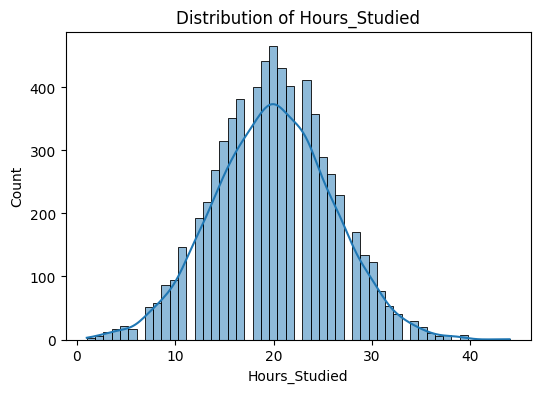

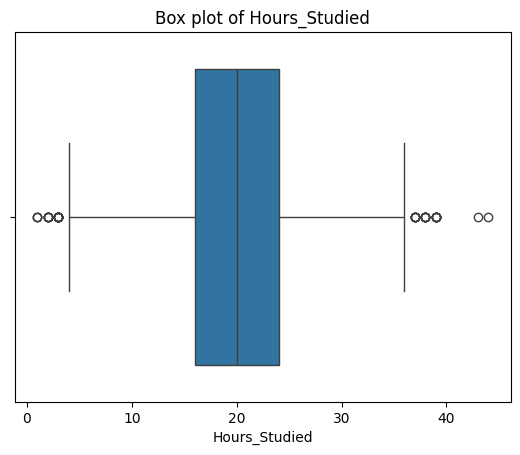

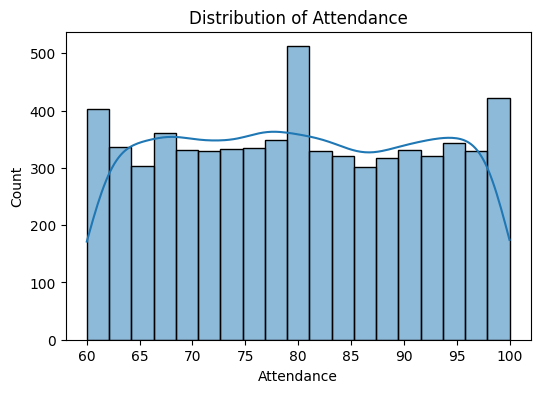

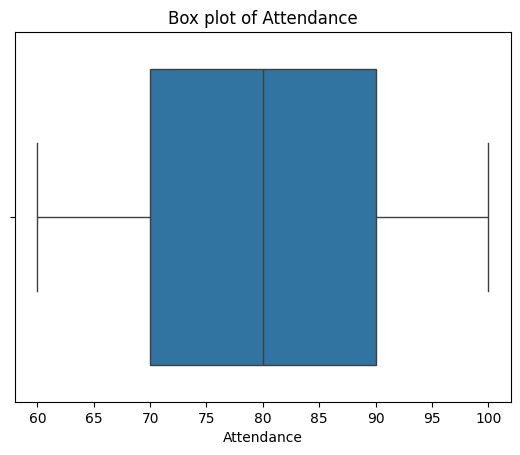

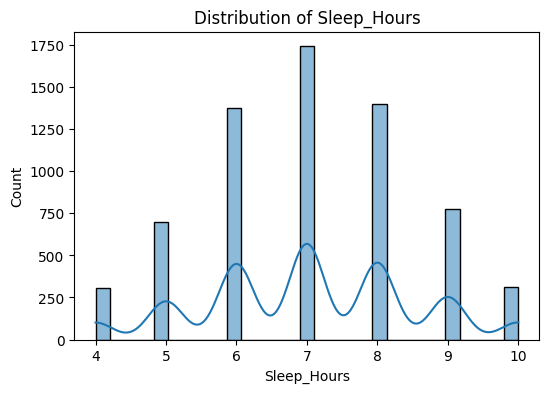

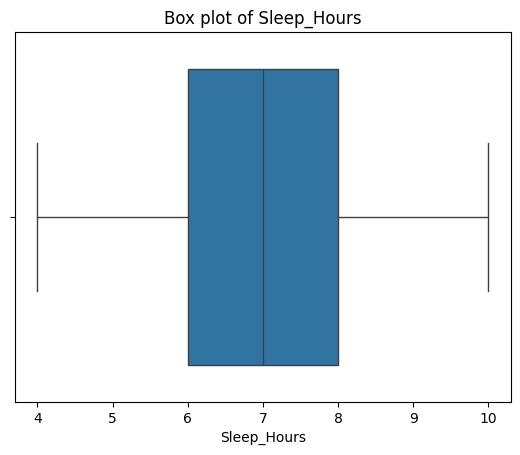

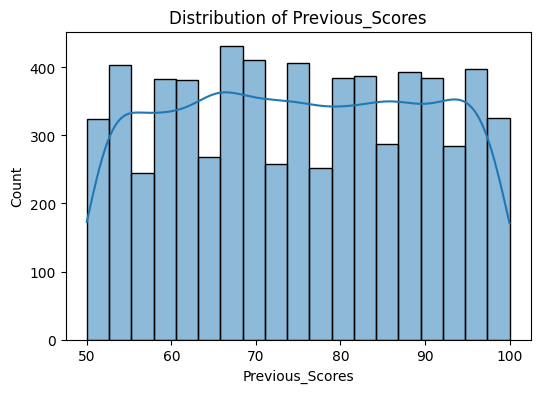

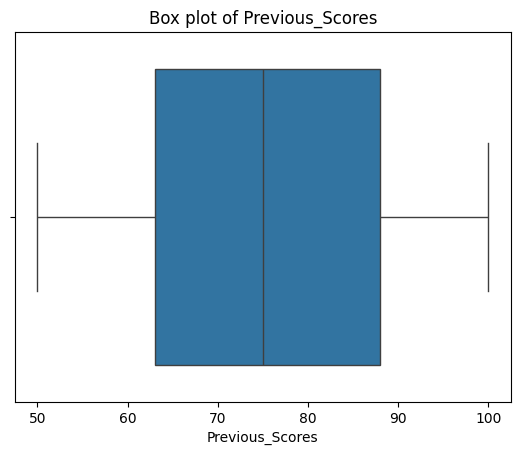

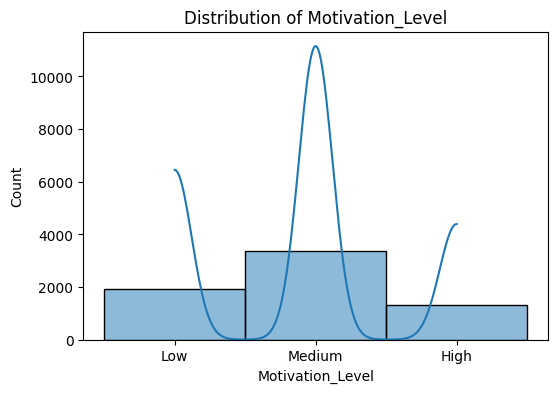

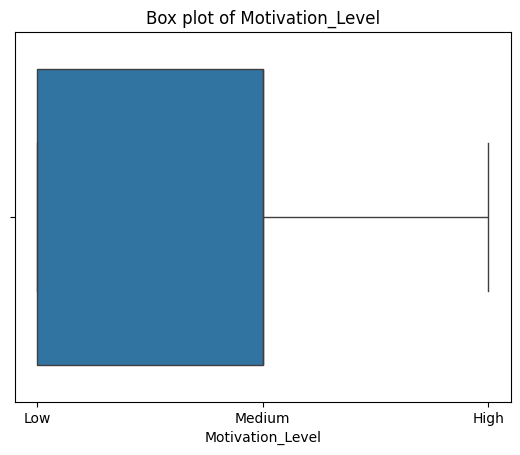

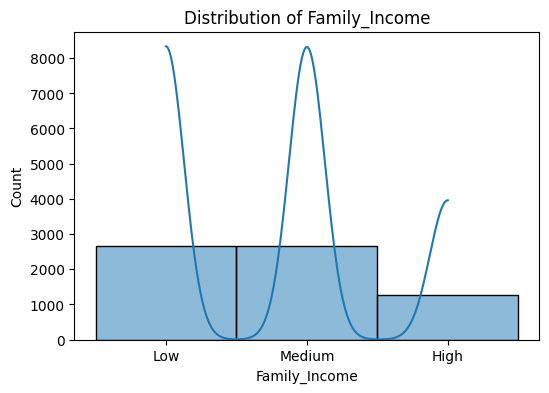

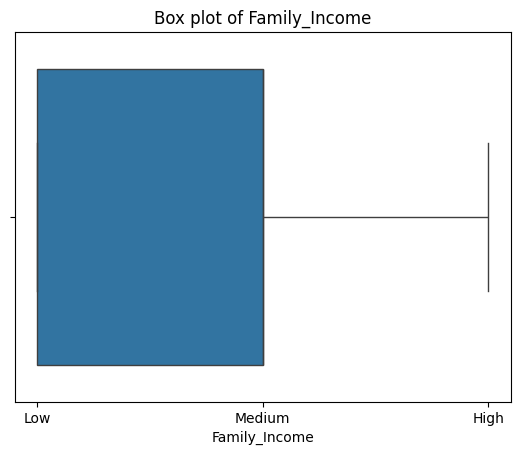

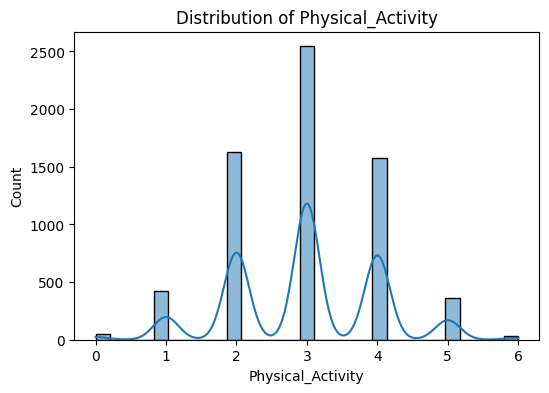

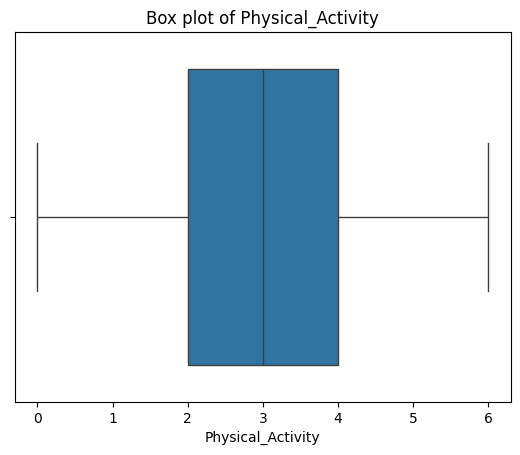

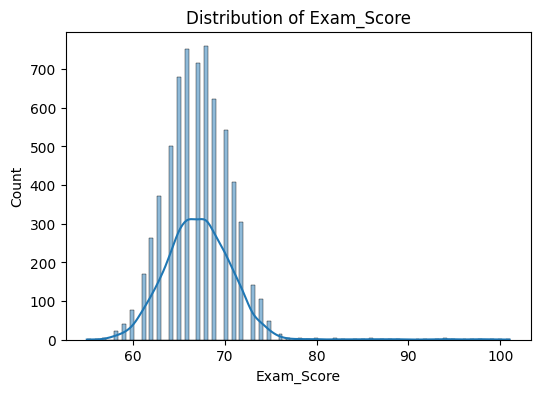

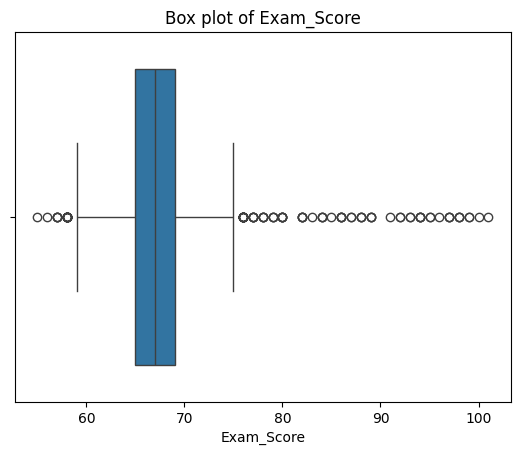

In [58]:
numerical_cols = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
                  'Motivation_Level', 'Family_Income', 'Physical_Activity', 'Exam_Score']
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(large_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    sns.boxplot(x=large_df[col])
    plt.title(f'Box plot of {col}')
    plt.show()


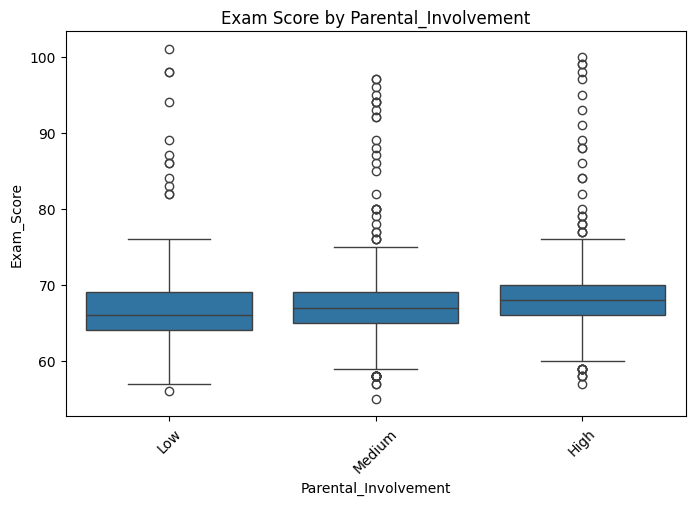

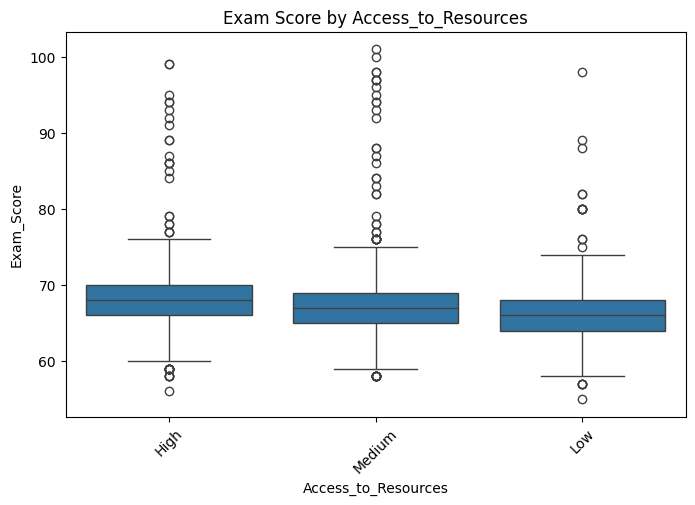

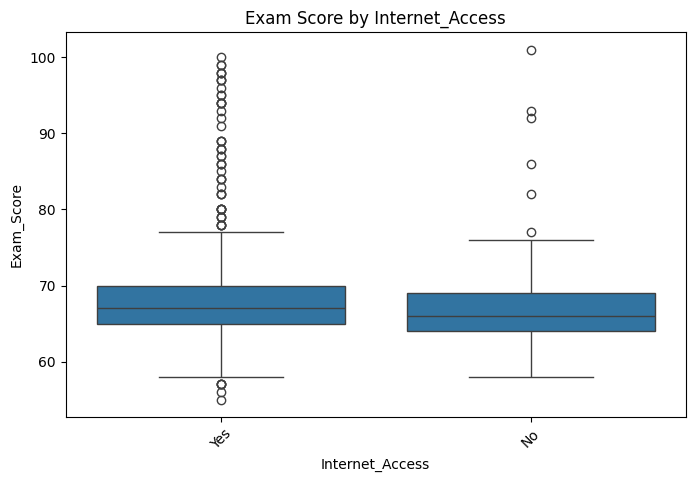

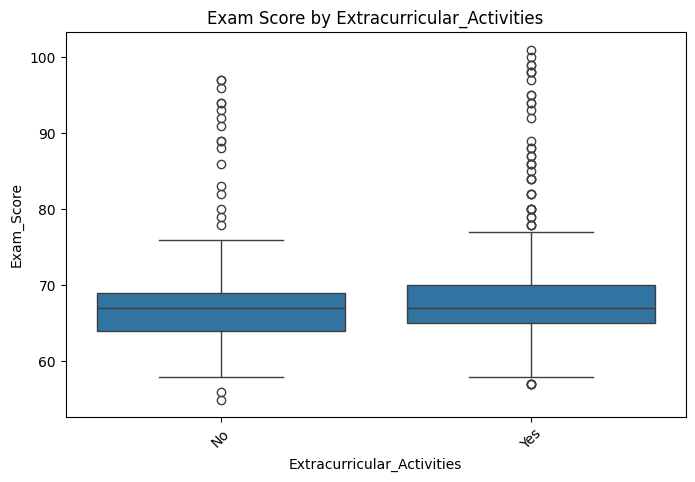

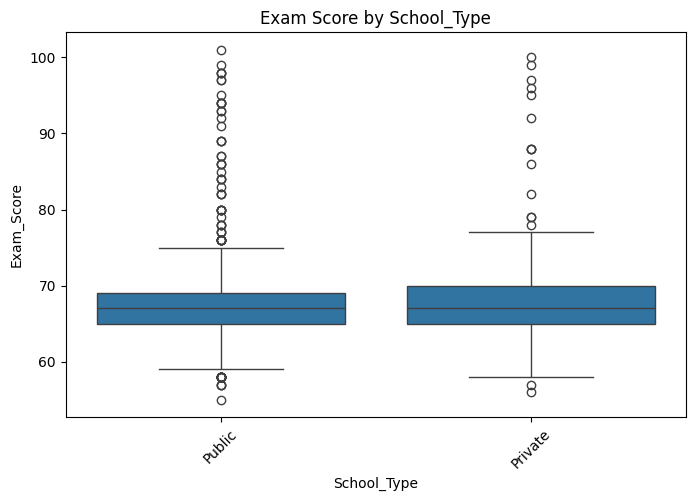

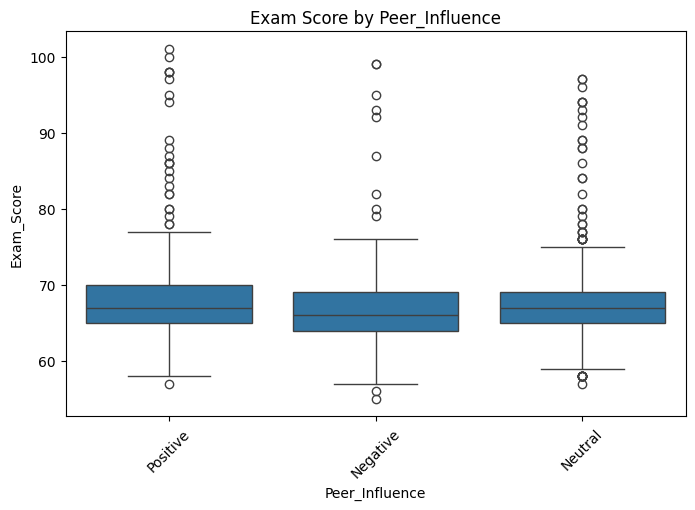

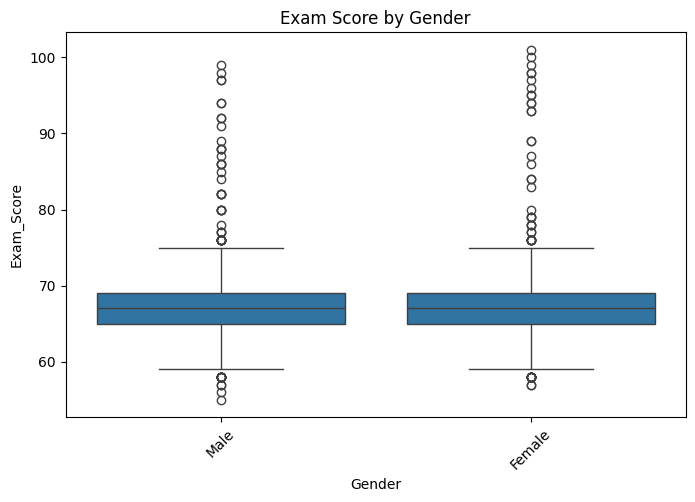

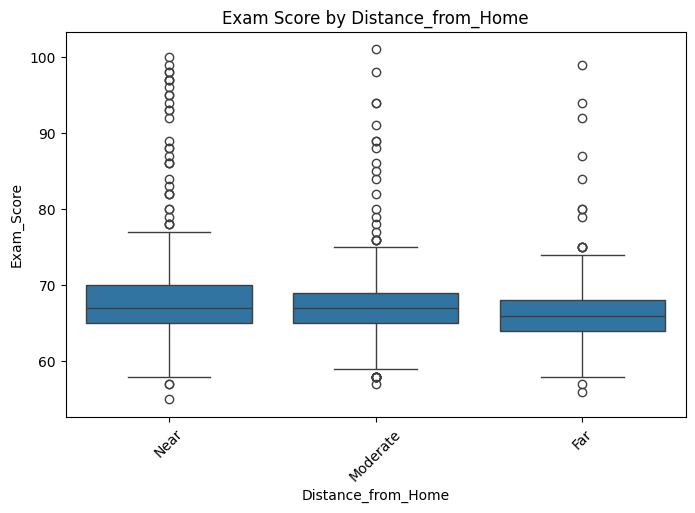

In [59]:
# categorical versus exam scores
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=col, y='Exam_Score', data=large_df)
    plt.title(f'Exam Score by {col}')
    plt.xticks(rotation=45)
    plt.show()


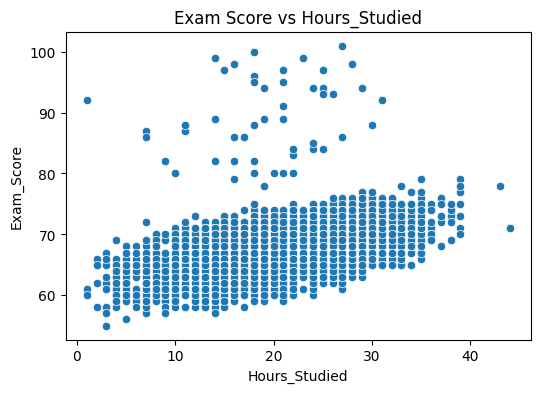

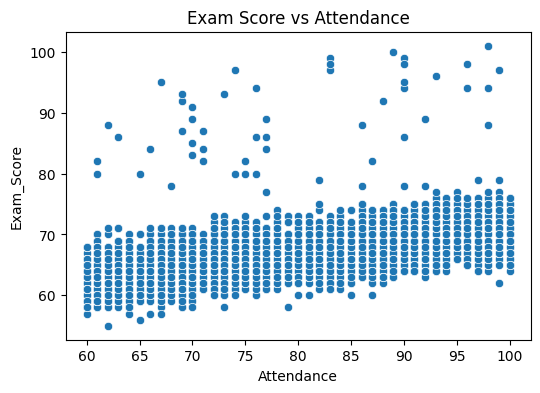

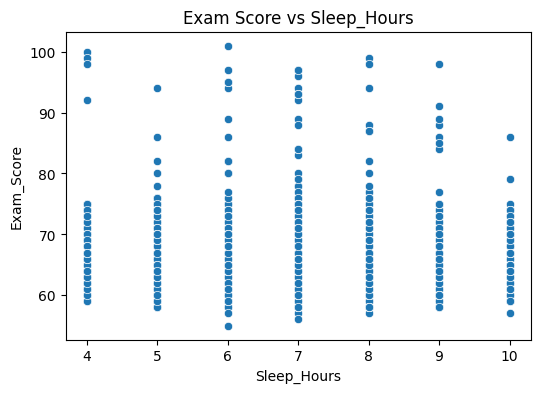

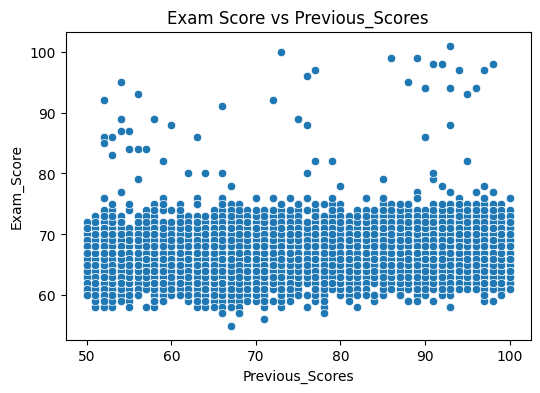

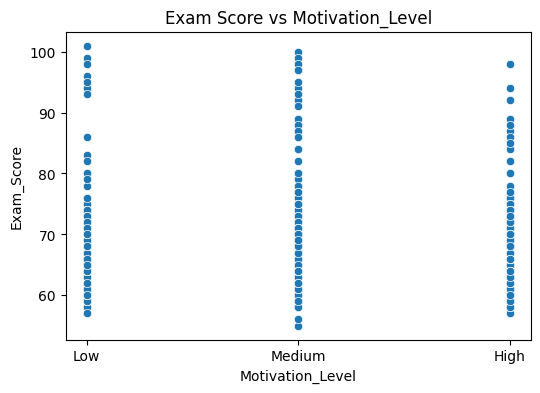

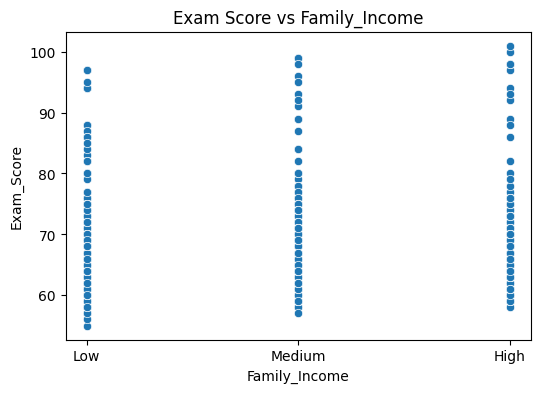

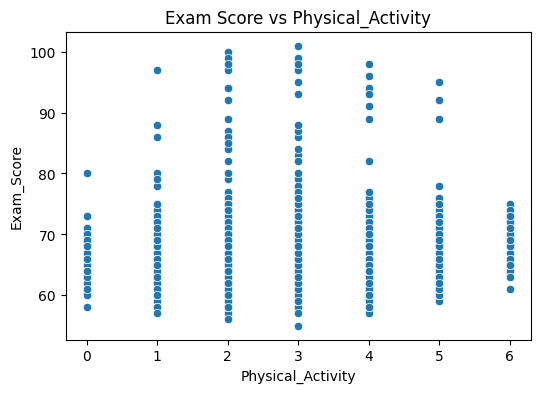

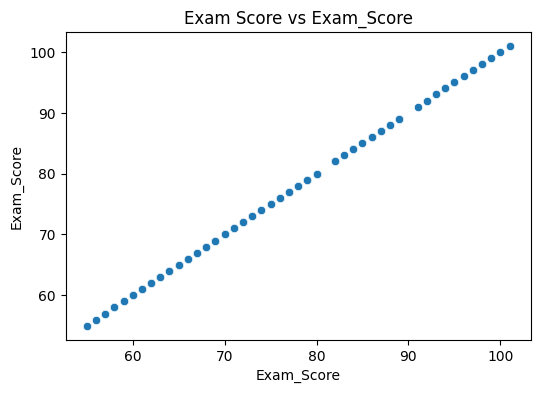

In [60]:
# numerical versus exam scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=col, y='Exam_Score', data=large_df)
    plt.title(f'Exam Score vs {col}')
    plt.show()


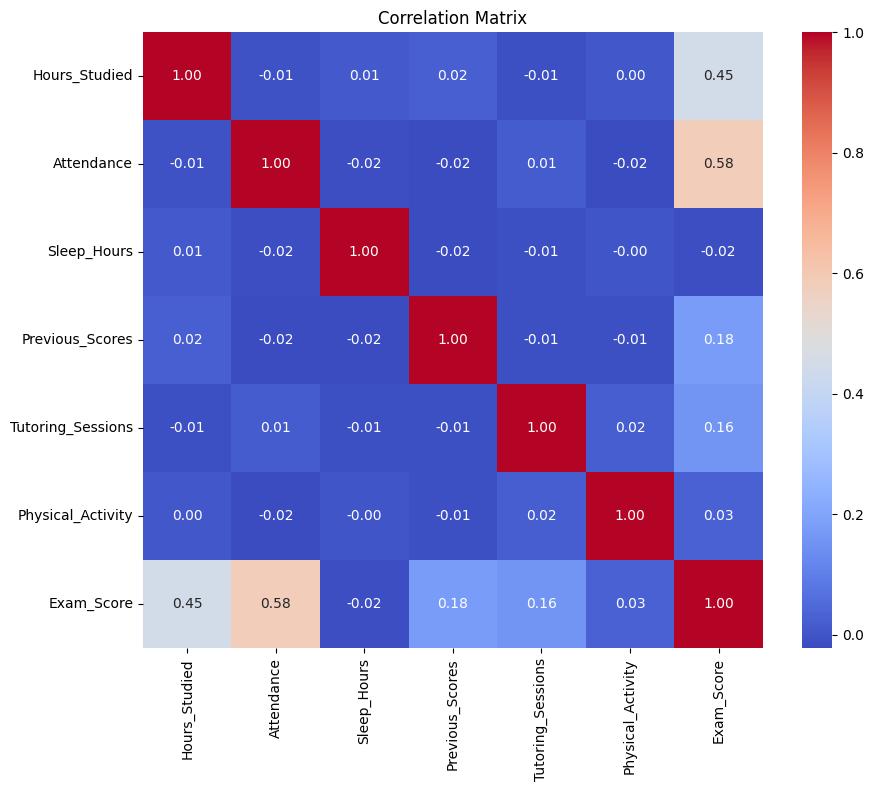

In [61]:
# Correlation heatmap
numerical_data = large_df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
